# Quantifying generalizations to new gaussians
This tests the response of models to gaussians in the -0.2 to 1.2 range and STDs 0.1 to 0.5. 


* Cortex only RNN, continually learned, and towards the bottom with shuffled data. 
* Cortex + MD context model.
* Cortex + MD context and variance model.
* Note Cortex + MD variance model was moved to generalization_for_Halassa.ipynb (excluded from results for now but can be added)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
import tasks.generative_1d
from tasks.generative_1d import *
from train import *

In [3]:

def extract_gen_performance(logger, env):
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    if preds.shape[-1] == 2:
        preds = preds[:,:1] # take only the mean pred, not variance
    # if you get logger.timestep_data['context_name'] at [switch] you get the name of the upcoming context after the switch 
    switches_ts = env.env_logger['switches_ts']
    switches_ts = np.array(switches_ts)
    ts_before, ts_after = 20, 0
    mean_diff = []
    distances_from_mean = defaultdict(list)
    inferred_means = defaultdict(list)
    mean_abs_errors = defaultdict(list)
    for i, switch in enumerate(switches_ts[1:]): # ignore the first and last switch
        if len (obs[switch-ts_before:switch+ts_after]) == ts_before+ts_after:
            mean_diff.append(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
        # so to get the id of the context before the switch you need to get the context name at the switch -1
            env_key = logger.timestep_data['context_names'][switch-1]
            mean = env.envs[env_key]['kwargs']['mean']
            distances_from_mean[mean].append(np.mean(np.abs((preds[switch-ts_before:switch+ts_after] - mean))))
            inferred_means[mean].append(np.mean(preds[switch-ts_before:switch+ts_after]))
            mean_abs_errors[mean].append(np.mean(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after]))))
        # calc MSE instead
        # mean_abs_errors[mean].append(np.square((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
    return distances_from_mean,inferred_means,mean_abs_errors

def plot_behavior_novel_contexts(logger, env,fig_height = 1.4):
    fig, axes = plt.subplots(1,2, figsize=(2.,1), dpi=100, sharey=True)
    ax = axes[0]
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    if preds.shape[-1] == 2:
        preds = preds [...,:1]
    ax.plot(obs, 'o', label='obs', markersize=0.5, color=obs_color)
    ax.plot(preds, 'o', label='preds', markersize=0.5, color=preds_color)
    switches_ts_padded = env.env_logger['switches_ts'] +[logger.timestep_data['timestep_i'][-1]]
    # ax.legend(loc='upper right', fontsize=6, ncol=2)
    # ax.legend(fontsize=6,)# loc='upper left')#loc=(.3,1.2))
    axes_labels(ax,'Time steps','Observations')
    ax.set_xticklabels([])
    ax.set_xlim(switches_ts_padded[7]-100, switches_ts_padded[7] )

    ax = axes[1]
    ax.plot(obs, 'o', label='obs', markersize=0.5, color=obs_color)
    ax.plot(preds, 'o', label='preds', markersize=0.5, color=preds_color)
    # ax.legend(loc='upper right', fontsize=6, ncol=2)
    # ax.legend(fontsize=6,)# loc='upper left')#loc=(.3,1.2))
    axes_labels(ax,'Time steps','Observations')
    ax.set_xticklabels([])
    ax.set_xlim(switches_ts_padded[7], switches_ts_padded[7] + 150)
    ax.set_ylim(-.5,2.5)
    plt.tight_layout()

    fig, axes = plt.subplots(1,8 , figsize=(9, fig_height), dpi=100, sharey=True)
    switches_ts = env.env_logger['switches_ts']
    for i in range(1, min(len(switches_ts)-1, 8), 1):
        ax = axes[i-1]
        ax.plot(obs, 'o', label='obs', markersize=0.5, color=obs_color)
        ax.plot(preds, 'o', label='preds', markersize=0.5, color=preds_color)
        # ax.legend(loc='upper right', fontsize=6, ncol=2)
        # ax.legend(fontsize=6,)# loc='upper left')#loc=(.3,1.2))
        axes_labels(ax,'Time steps','Observations')
        ax.set_xticklabels(['', '25', '75'])
        ax.set_xlim(switches_ts[i]-100, switches_ts[i] )

        switch_to_context_name = logger.timestep_data['context_names'][switches_ts[i-1]]
        context_mean = env.envs[switch_to_context_name]['kwargs']['mean']
        context_std = env.envs[switch_to_context_name]['kwargs']['std'] 
        ax.set_xlabel(f'{context_mean:.2f}±{context_std:.2f}')
    fig.tight_layout()

def plot_histograms_novel_contexts(logger, env, fig_height = 0.9):
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    # remove var output if exists
    if preds.shape[-1] == 2:
        preds = preds [...,:1]

    obs_color = 'tab:grey'
    preds_color = 'tab:red'

    fig, axes = plt.subplots(1, 8, figsize=(9, fig_height), dpi=100)

    # now plot the histogram for predictions from every other block according to the env.env_logger['switches_ts'] switch times
    switches_ts = env.env_logger['switches_ts']
    for i in range(0, min(len(switches_ts)-1, 8), 1):
        ax = axes[i]
        bins = np.linspace(-1.1, 1.6, 80)
        ax.hist(preds[switches_ts[i]:switches_ts[i+1]], bins= bins, alpha=0.75, label='preds', color=preds_color)
        ax.set_title(f'mean: {np.mean(preds[switches_ts[i]:switches_ts[i+1]]):.2f}')
        ax.hist(obs[switches_ts[i]:switches_ts[i+1]], bins= bins, alpha=0.65, label='obs', color=obs_color)
        pltu.axes_labels(ax, 'Predictions', 'Count')
        # for the first 2 axes resize the plot to 2/3 its height.
        switch_to_context_name = logger.timestep_data['context_names'][switches_ts[i]]
        context_mean = env.envs[switch_to_context_name]['kwargs']['mean']
        context_std = env.envs[switch_to_context_name]['kwargs']['std']
        ax.set_xlabel(f'{context_mean:.2f}±{context_std:.2f}')

        


#### First case: Cortex only RNN

### Train an RNN

In [4]:
config = Config()
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), }
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
train_steps = int(100 * scale)
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 7

_use_oracle = False
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)


In [5]:
#Test generalization:
def test_generalization(model, _use_optimized_thalamus=False, novel_std=0.3):
    _use_oracle = False
    
    config= Config(context_units=2)
    scale = 20
    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

    means = np.array(list(range(-2, 13)))/10
    env = Generative_environment(config, experiment=3, novel_std=novel_std)
    horizon = 3
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.50, momentum=0.5)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env


# memory_buffer_RNN,  losses_RNN , env_RNN= test_generalization(model)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

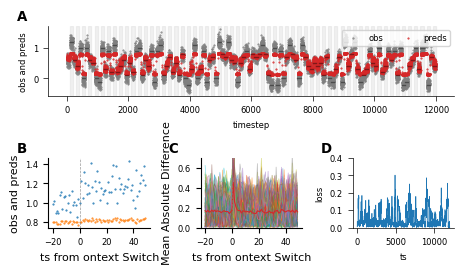

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

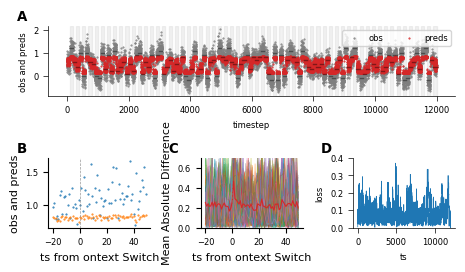

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

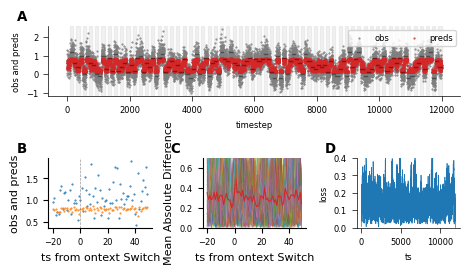

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

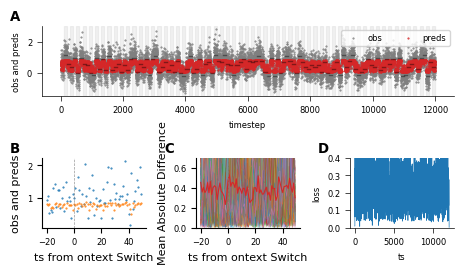

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

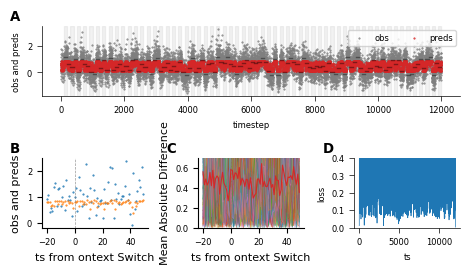

In [6]:
stds = [0.1, 0.2, 0.3, 0.4, 0.5]
memory_buffers_RNN = []
losseses_RNN = []
envs_RNN = []
for std in stds:
    memory_buffer_RNN,  losses_RNN , env_RNN= test_generalization(model, novel_std=std)
    memory_buffers_RNN.append(memory_buffer_RNN)
    losseses_RNN.append(losses_RNN)
    envs_RNN.append(env_RNN)


#### Plot RNN only


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

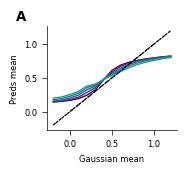

In [7]:
fig, axes = plt.subplot_mosaic([['A']],
                            constrained_layout=False, figsize = [5/2.53, 4.5/2.53])
                            # constrained_layout=False, figsize = [12/2.53, 7/2.53])
import matplotlib.transforms as mtransforms
for label, ax in axes.items():
    # label physical distance to the left and up: (left, up) raise up to move label up
    trans = mtransforms.ScaledTranslation(-23/72, 2/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
        fontsize='large', va='bottom', fontfamily='arial',weight='bold')

with_context_color = 'tab:blue'
no_context_color = 'tab:orange'

means = np.array(list(range(-2, 13)))/10

def extract_gen_performance(logger, env):
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    if preds.shape[-1] == 2:
        preds = preds[:,:1] # take only the mean pred, not variance
# if you get logger.timestep_data['context_name'] at [switch] you get the name of the upcoming context after the switch 
    switches_ts = env.env_logger['switches_ts']
    switches_ts = np.array(switches_ts)
    ts_before, ts_after = 20, 0
    mean_diff = []
    distances_from_mean = defaultdict(list)
    inferred_means = defaultdict(list)
    mean_abs_errors = defaultdict(list)
    for i, switch in enumerate(switches_ts[1:]): # ignore the first and last switch
        if len (obs[switch-ts_before:switch+ts_after]) == ts_before+ts_after:
            mean_diff.append(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
        # so to get the id of the context before the switch you need to get the context name at the switch -1
            env_key = logger.timestep_data['context_names'][switch-1]
            mean = env.envs[env_key]['kwargs']['mean']
            distances_from_mean[mean].append(np.mean(np.abs((preds[switch-ts_before:switch+ts_after] - mean))))
            inferred_means[mean].append(np.mean(preds[switch-ts_before:switch+ts_after]))
            mean_abs_errors[mean].append(np.mean(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after]))))
        # calc MSE instead
        # mean_abs_errors[mean].append(np.square((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))

    means = list(distances_from_mean.keys())
    means = np.array(means)
    means.sort()
    return distances_from_mean,inferred_means,mean_abs_errors

distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffer_RNN,env_RNN)

distances_from_mean_RNN = distances_from_mean
inferred_means_RNN = inferred_means
mean_abs_errors_RNN = mean_abs_errors


all_distances_from_mean_RNN = []
all_inferred_means_RNN = []
all_mean_abs_errors_RNN = []


for si,std_ in enumerate(stds):
    distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_RNN[si],envs_RNN[si])
    all_distances_from_mean_RNN.append(distances_from_mean)
    all_inferred_means_RNN.append(inferred_means)
    all_mean_abs_errors_RNN.append(mean_abs_errors)

########################### to do: continue refavctoricng from here..............
# change color scheme to viridis
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, 3+len(stds)))


# plot inferred means
for si,std_ in enumerate(stds):
    distances_from_mean_RNN = all_distances_from_mean_RNN[si]
    inferred_means_RNN = all_inferred_means_RNN[si]
    mean_abs_errors_RNN = all_mean_abs_errors_RNN[si]

    ax = axes['A']
    inferred_RNN = [np.array(inferred_means_RNN[mean]).mean() for mean in means]
    stds_RNN = [np.array(inferred_means_RNN[mean]).std() for mean in means]
    ax.plot( means, inferred_RNN, label=f'STD ' + str(std_), linewidth=1, color=colors[si])# color= no_context_color)
    # ax.fill_between(means, np.array(inferred_RNN) - np.array(stds_RNN), np.array(inferred_RNN) + np.array(stds_RNN), alpha=0.2, color= no_context_color)
    ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    axes_labels(ax, 'True observations mean', 'Predictions mean')
    # ax.legend(fontsize=6)
    # ax.set_title('RNN only')


# ax.set_title('inferred means')
axes_labels(ax, 'Gaussian mean', 'Preds mean')
# ax.legend(fontsize=6)
# draw a diagonal line
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)
fig.tight_layout()
fig.savefig('./exports/RNN_only_generalization2.PDF', dpi=300)

In [8]:
#Test generalization. New code for the functional implementation:
def run_exp_generalization_space_RNN(model, _use_optimized_thalamus=False, novel_std=0.3):
    _use_oracle = False
    
    config= Config(context_units=2)
    scale = 20
    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    env = Generative_environment(config, experiment=3, novel_std=novel_std)
    horizon = 5
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.00000050, momentum=0.5)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        0, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    # plot_behavior(memory_buffer, env, losses, config, False )
    # if _use_/optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env

stds = [0.1, 0.2, 0.3, 0.4, 0.5]
memory_buffers_RNN_generalization_all = []
envs_RNN_generalization_all = []
for std in stds:
    memory_buffer_RNN_generalization_all,  losses_RNN_generalization_all , env_RNN_generalization_all= run_exp_generalization_space_RNN(model_RNN, novel_std=std)
    memory_buffers_RNN_generalization_all.append(memory_buffer_RNN_generalization_all)
    envs_RNN_generalization_all.append(env_RNN_generalization_all)

fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
plot_all_generalization_lines(memory_buffers_RNN_generalization_all, envs_RNN_generalization_all, axes, title='RNN only', stds=stds, means=means)
# plt.savefig('./exports/generalization_RNN_only_zoomed_in.pdf', bbox_inches='tight')


NameError: name 'model_RNN' is not defined


### Second case: RNN+Context MD

In [ ]:
config = Config(context_units=2)
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), }
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
train_steps = int(100 * scale)
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 7

_use_oracle = True
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

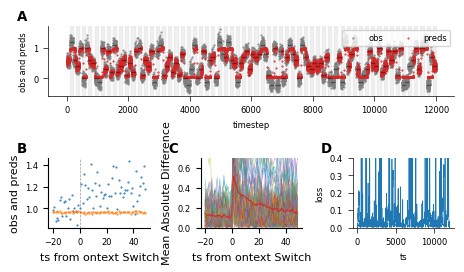

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

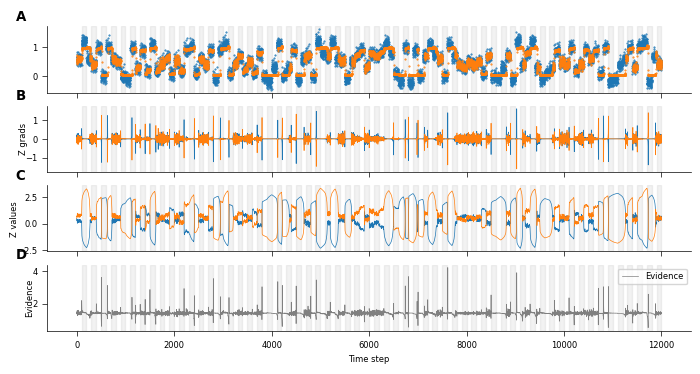

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

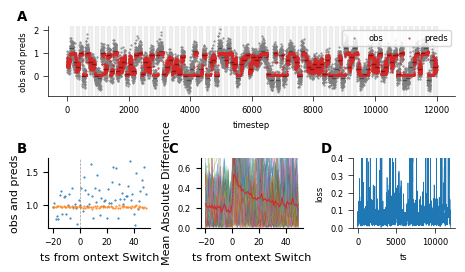

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

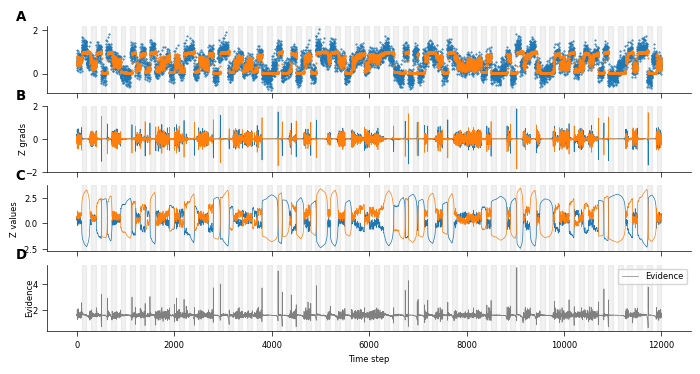

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

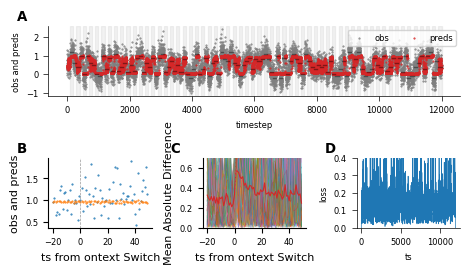

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

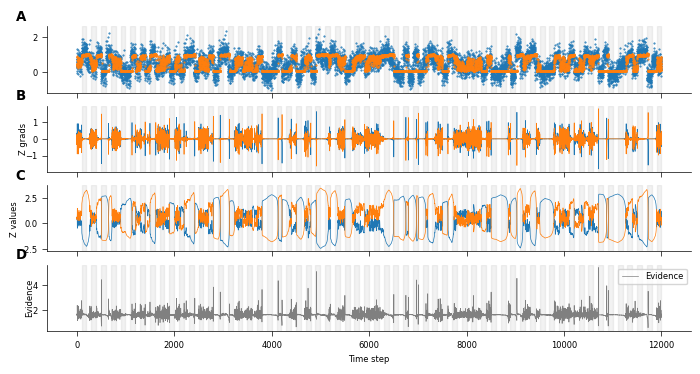

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

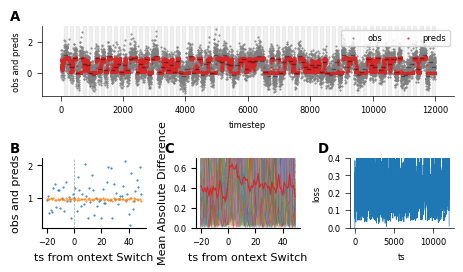

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

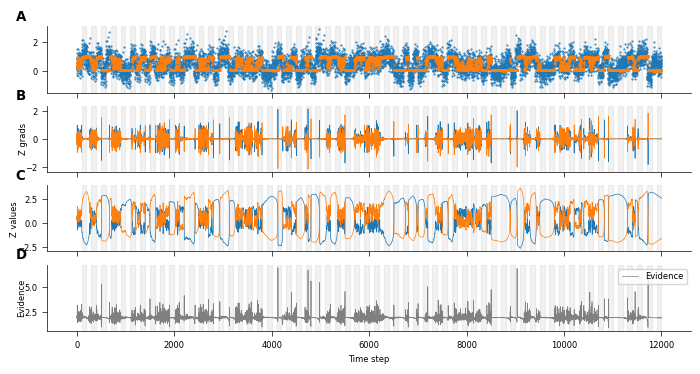

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

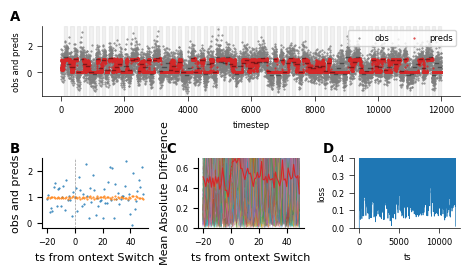

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

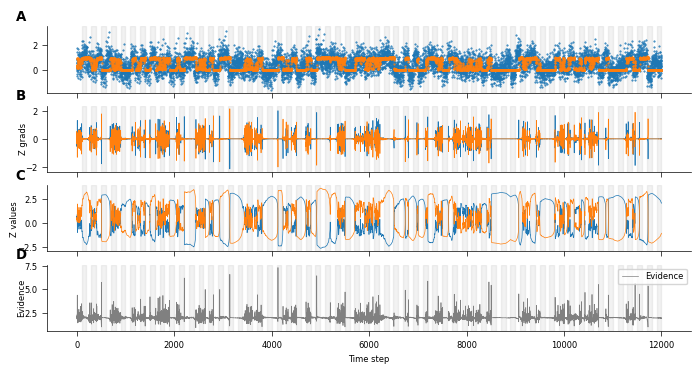

In [ ]:
memory_buffers_NBN = []
lossess_NBN = []
envs_NBN = []
for std in stds:
    memory_buffer_NBN,  losses_NBN , env_NBN= test_generalization(model, _use_optimized_thalamus=True, novel_std=std)
    memory_buffers_NBN.append(memory_buffer_NBN)
    lossess_NBN.append(losses_NBN)
    envs_NBN.append(env_NBN)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

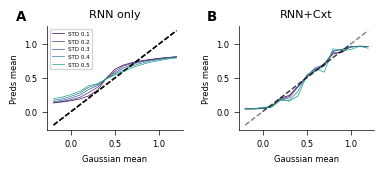

In [ ]:
fig, axes = plt.subplot_mosaic([['A','B']],
                            constrained_layout=False, figsize = [10/2.53, 4.5/2.53])
                            # constrained_layout=False, figsize = [12/2.53, 7/2.53])
import matplotlib.transforms as mtransforms
for label, ax in axes.items():
    # label physical distance to the left and up: (left, up) raise up to move label up
    trans = mtransforms.ScaledTranslation(-23/72, 2/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
        fontsize='large', va='bottom', fontfamily='arial',weight='bold')

with_context_color = 'tab:blue'
no_context_color = 'tab:orange'

means = np.array(list(range(-2, 13)))/10

def extract_gen_performance(logger, env):
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    if preds.shape[-1] == 2:
        preds = preds[:,:1] # take only the mean pred, not variance
# if you get logger.timestep_data['context_name'] at [switch] you get the name of the upcoming context after the switch 
    switches_ts = env.env_logger['switches_ts']
    switches_ts = np.array(switches_ts)
    ts_before, ts_after = 20, 0
    mean_diff = []
    distances_from_mean = defaultdict(list)
    inferred_means = defaultdict(list)
    mean_abs_errors = defaultdict(list)
    for i, switch in enumerate(switches_ts[1:]): # ignore the first and last switch
        if len (obs[switch-ts_before:switch+ts_after]) == ts_before+ts_after:
            mean_diff.append(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
        # so to get the id of the context before the switch you need to get the context name at the switch -1
            env_key = logger.timestep_data['context_names'][switch-1]
            mean = env.envs[env_key]['kwargs']['mean']
            distances_from_mean[mean].append(np.mean(np.abs((preds[switch-ts_before:switch+ts_after] - mean))))
            inferred_means[mean].append(np.mean(preds[switch-ts_before:switch+ts_after]))
            mean_abs_errors[mean].append(np.mean(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after]))))
        # calc MSE instead
        # mean_abs_errors[mean].append(np.square((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))

    means = list(distances_from_mean.keys())
    means = np.array(means)
    means.sort()
    return distances_from_mean,inferred_means,mean_abs_errors

distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffer_RNN,env_RNN)

distances_from_mean_RNN = distances_from_mean
inferred_means_RNN = inferred_means
mean_abs_errors_RNN = mean_abs_errors

distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffer_NBN,env_NBN)

distances_from_mean_NBN = distances_from_mean
inferred_means_NBN = inferred_means
mean_abs_errors_NBN = mean_abs_errors

all_distances_from_mean_RNN = []
all_inferred_means_RNN = []
all_mean_abs_errors_RNN = []

all_distances_from_mean_NBN = []
all_inferred_means_NBN = []
all_mean_abs_errors_NBN = []

for si,std_ in enumerate(stds):
    distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_RNN[si],envs_RNN[si])
    all_distances_from_mean_RNN.append(distances_from_mean)
    all_inferred_means_RNN.append(inferred_means)
    all_mean_abs_errors_RNN.append(mean_abs_errors)

    distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_NBN[si],envs_NBN[si])
    all_distances_from_mean_NBN.append(distances_from_mean)
    all_inferred_means_NBN.append(inferred_means)
    all_mean_abs_errors_NBN.append(mean_abs_errors)

########################### to do: continue refavctoricng from here..............
# change color scheme to viridis
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, 3+len(stds)))


# plot inferred means
for si,std_ in enumerate(stds):
    distances_from_mean_RNN = all_distances_from_mean_RNN[si]
    inferred_means_RNN = all_inferred_means_RNN[si]
    mean_abs_errors_RNN = all_mean_abs_errors_RNN[si]

    distances_from_mean_NBN = all_distances_from_mean_NBN[si]
    inferred_means_NBN = all_inferred_means_NBN[si]
    mean_abs_errors_NBN = all_mean_abs_errors_NBN[si]

    ax = axes['A']
    inferred_RNN = [np.array(inferred_means_RNN[mean]).mean() for mean in means]
    stds_RNN = [np.array(inferred_means_RNN[mean]).std() for mean in means]
    inferred_NBN = [np.array(inferred_means_NBN[mean]).mean() for mean in means]
    stds_NBN = [np.array(inferred_means_NBN[mean]).std() for mean in means]
    ax.plot( means, inferred_RNN, label=f'STD ' + str(std_), linewidth=0.5, color=colors[si])# color= no_context_color)
    # ax.fill_between(means, np.array(inferred_RNN) - np.array(stds_RNN), np.array(inferred_RNN) + np.array(stds_RNN), alpha=0.2, color= no_context_color)
    ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)
    axes_labels(ax, 'Gaussian mean', 'Preds mean')
    ax.legend(fontsize=4)
    ax.set_title('RNN only')
    ax = axes['B']
    ax.plot( means, inferred_NBN, label='LSTM-MD_' + str(std_), linewidth=0.5, color=colors[si])# color=with_context_color)
    ax.set_title('RNN+Cxt')
    # ax.fill_between(means, np.array(inferred_NBN) - np.array(stds_NBN), np.array(inferred_NBN) + np.array(stds_NBN), alpha=0.2, color=with_context_color)


# ax.set_title('inferred means')
axes_labels(ax, 'Gaussian mean', 'Preds mean')
# ax.legend(fontsize=6)
# draw a diagonal line
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)
fig.tight_layout()
# fig.savefig('./exports/var_quantifying_generalization_RNN_NBN.png', dpi=300)

# Training with variance input to MD as well
Repeat the same experiments as above, but expand to a model with 4 MD neurons, 2 for context input and 2 for variance. 

In [ ]:
# config = Config()
scale = 20 ###############################################################################################################################
std = 0.3
# config = Config(env_kwargs= { 'gauss1': {'mean': 0.3, 'std': 0.3}, 'gauss2': {'mean': 0.7, 'std': 0.1}, 'gauss3': {'mean': 0.3, 'std': 0.1}}, context_units=4)
# config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.3}, 'gauss2': {'mean': 0.9, 'std': 0.1}, 'gauss3': {'mean': 0.1, 'std': 0.1}}, context_units=4)
config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.3}, 'gauss2': {'mean': 0.9, 'std': 0.1}, 'gauss3': {'mean': 0.1, 'std': 0.1}}, context_units=4)
# config.context_signal_type = 'compositional'
l2_loss = 0.1
ablate_context = False

In [ ]:
def mse_ignore_var(output, target):
    mu = output[..., :1]
#     sigma = output[..., 1:]
    z = F.mse_loss(mu, target, reduction='none')#/sigma
    total_loss = torch.sum(z) #+ alpha * torch.sum(sigma)
    return total_loss

def criterion_var_scaled(output, target):
    mu = output[..., :1]
    sigma = output[..., 1:]

    # variance modulated loss:
    z = F.mse_loss(mu, target, reduction='none')/sigma
    alpha = 0.3
    total_loss = torch.sum(z) + alpha * torch.sum(sigma)

    return total_loss

config.ablate_context_signal = ablate_context
capture_variance_experiment = True
# Added cell to test training with different std
config.capture_variance_experiment = capture_variance_experiment
if config.capture_variance_experiment:
        config.output_size = 2
        # criterion = mse_ignore_var
        criterion = criterion_var_scaled
else:
        config.output_size = 1
        criterion = nn.MSELoss(reduction='sum')
        

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

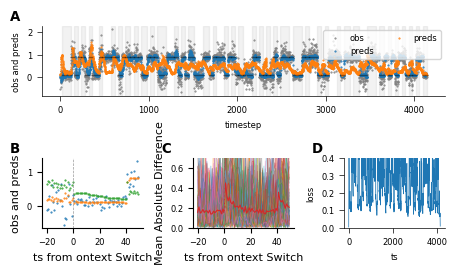

In [ ]:
config.context_signal_type = 'compositional'
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 
         'no_of_blocks': 80 } 
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config, experiment=2, novel_mean=0.9, novel_std=0.3)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 7
config.l2_loss = False
_use_oracle = True
memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, criterion, ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )


########################### testing behavior of RNN cxt var

########################### testing behavior of RNN cxt var

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

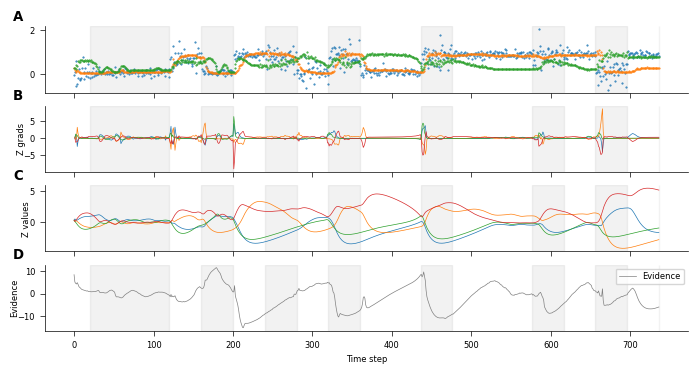

In [ ]:
#################################### TESTING ########################################
testing_blocks =15
config.training_phases[0]['config']['no_of_blocks'] = testing_blocks
testing_env = Generative_environment(config, experiment=2, novel_mean=0.8, novel_std=0.3)
# horizon = 5
# optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.10, momentum=0.5) ###############################################################################################################################
optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=0.2,   ) #lr=.20, weight_decay=0.01)
logger = Logger(config)
# criterion = nn.MSELoss(reduction='sum')
config.l2_loss = l2_loss
_use_oracle = False
_use_optimized_thalamus = True
testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus, )
plot_grads(testing_memory_buffer, testing_env, )

In [ ]:
#Test generalization:
def test_generalization(model, _use_optimized_thalamus=False, novel_std=0.1):
    _use_oracle = False
    # config = generalization_mean_and_var_Config (context_units=4)
    config= Config(context_units=4)
    scale = 20
    config.capture_variance_experiment = True
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')
            

    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

    means = np.array(list(range(-2, 13)))/10
    env = Generative_environment(config, experiment=3, novel_std=novel_std)
    horizon = 7
    # optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.50, momentum=0.5)
    config.l2_loss = l2_loss
    optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=0.2,   ) #lr=.20, weight_decay=0.01)
    # criterion = nn.MSELoss(reduction='sum')

    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )
    return memory_buffer, losses, env


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

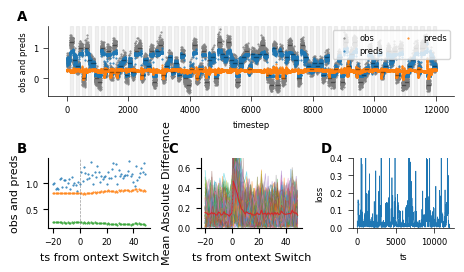

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

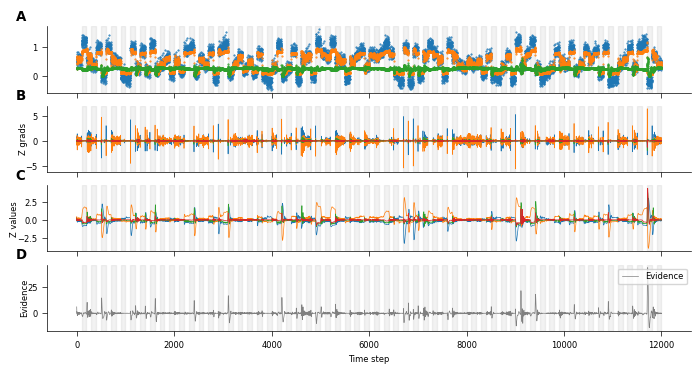

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

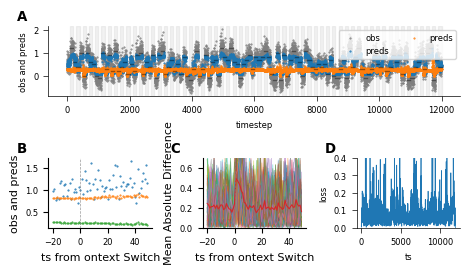

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

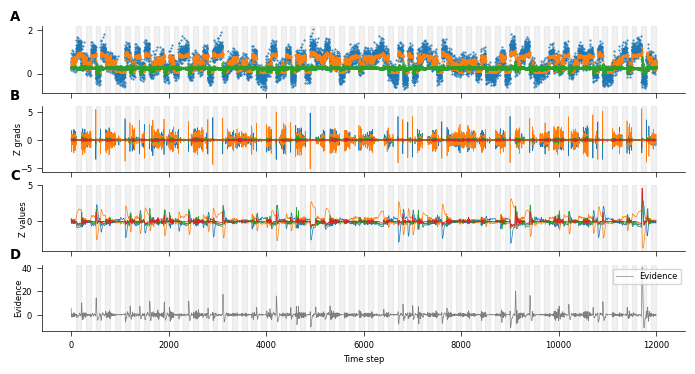

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

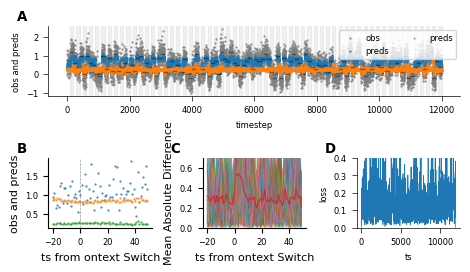

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

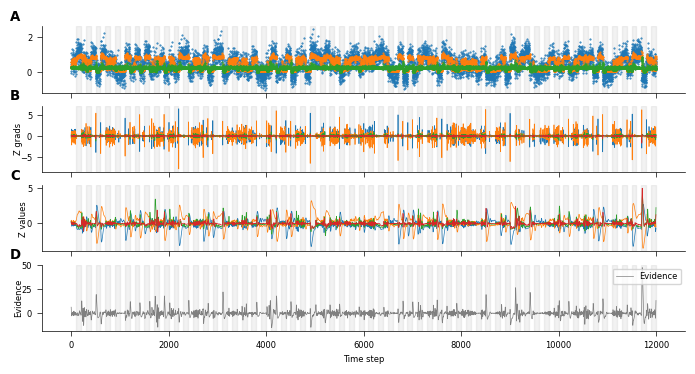

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

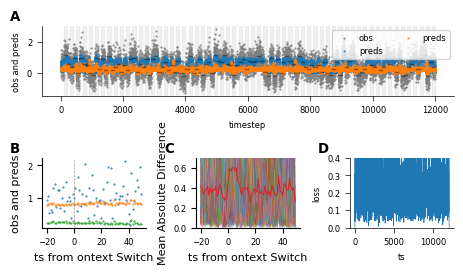

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

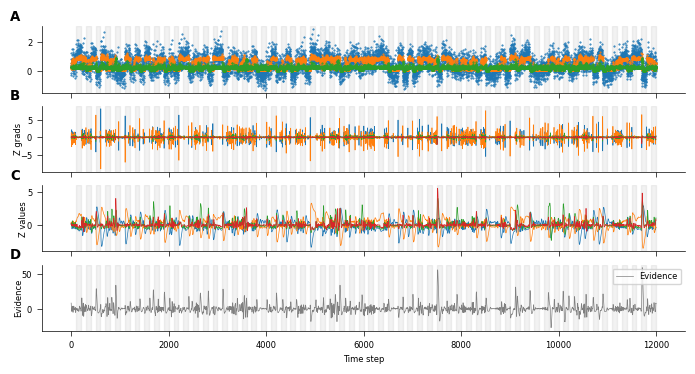

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

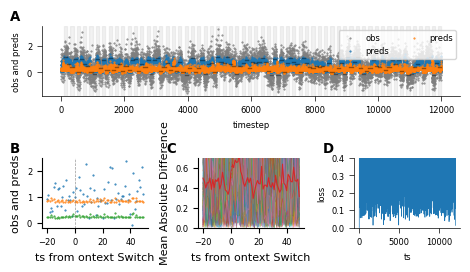

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

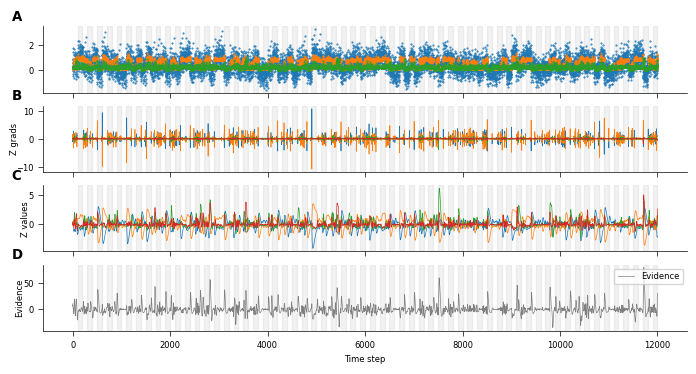

In [ ]:
stds = [0.1, 0.2, 0.3, 0.4, 0.5]
memory_buffers_RNN_cxt_var = []
losseses_RNN_cxt_var = []
envs_RNN_cxt_var = []
for std in stds:
    memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= test_generalization(model, _use_optimized_thalamus=True, novel_std=std)
    memory_buffers_RNN_cxt_var.append(memory_buffer_RNN_cxt_var)
    losseses_RNN_cxt_var.append(losses_RNN_cxt_var)
    envs_RNN_cxt_var.append(env_RNN_cxt_var)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

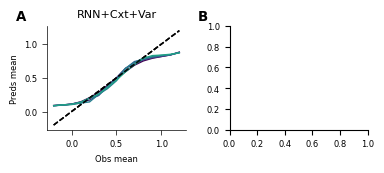

In [ ]:
fig, axes = plt.subplot_mosaic([['A','B']],
                            constrained_layout=False, figsize = [10/2.53, 4.5/2.53])
                            # constrained_layout=False, figsize = [12/2.53, 7/2.53])
import matplotlib.transforms as mtransforms
for label, ax in axes.items():
    # label physical distance to the left and up: (left, up) raise up to move label up
    trans = mtransforms.ScaledTranslation(-23/72, 2/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
        fontsize='large', va='bottom', fontfamily='arial',weight='bold')

with_context_color = 'tab:blue'
no_context_color = 'tab:orange'

means = np.array(list(range(-2, 13)))/10

all_distances_from_mean_RNN = []
all_inferred_means_RNN = []
all_mean_abs_errors_RNN = []

for si,std_ in enumerate(stds):
    distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_RNN_cxt_var[si],envs_RNN_cxt_var[si])
    # distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_RNN_cxt_var[si],envs_RNN_cxt_var[si])
    all_distances_from_mean_RNN.append(distances_from_mean)
    all_inferred_means_RNN.append(inferred_means)
    all_mean_abs_errors_RNN.append(mean_abs_errors)

plot_mean_std_lines('RNN+Cxt+Var', axes, means, all_distances_from_mean_RNN, all_inferred_means_RNN, all_mean_abs_errors_RNN)
fig.tight_layout()
# fig.savefig('./exports/quantifiying_generalization_Cxt_VAR.pdf', dpi=300)

In [ ]:
sweep_params = False

def run_exp_generalization_space_RNN_cxt_var(model, _use_optimized_thalamus=False, novel_std=0.1, lr = None, momentum = None, gradient_clipping = None, l2_loss = None, use_adam_optimizer = False):
    _use_oracle = False
    # config = generalization_mean_and_var_Config (context_units=4)
    config= Config(context_units=4)
    scale = 20
    config.capture_variance_experiment = True
    # config.capture_variance_experiment = capture_variance_experiment
    if config.capture_variance_experiment:
            config.output_size = 2
            # criterion = criterion_var_scaled
            criterion = mse_ignore_var
            # criterion = criterion_gaussian_log_likelihood
    else:
            config.output_size = 1
            criterion = nn.MSELoss(reduction='sum')

    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8*15} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    means = np.array(list(range(-2, 13)))/10
    env = Generative_environment(config, experiment=3, novel_std=novel_std)
    horizon = 7
    if lr is None:
        lr = 0.2
    if momentum is None:
        momentum = 0.1
    if l2_loss is None:
        l2_loss = 0.03
    if gradient_clipping is None:
        gradient_clipping = 0

    config.l2_loss = l2_loss
    config.gradient_clipping = gradient_clipping
    if use_adam_optimizer:
        optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=lr,   ) #lr=.20, weight_decay=0.01)
    else:
        optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr= lr, momentum=momentum  ) #lr=.20, weight_decay=0.01)

    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    # plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    # if _use_optimized_thalamus: plot_grads(memory_buffer, env, )
    return memory_buffer, losses, env
def run_gen_exp(model, l2_loss=0.06):
    memory_buffers_RNN_cxt_var = []
    losseses_RNN_cxt_var = []
    envs_RNN_cxt_var = []
    for std in stds:
        memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_generalization_space_RNN_cxt_var(model, _use_optimized_thalamus=True, novel_std=std,
        use_adam_optimizer=True, lr=0.2, l2_loss=l2_loss)
        # lr = 0.1, momentum = 0.1, gradient_clipping = 0, l2_loss = 0.03)
        # )
        memory_buffers_RNN_cxt_var.append(memory_buffer_RNN_cxt_var)
        losseses_RNN_cxt_var.append(losses_RNN_cxt_var)
        envs_RNN_cxt_var.append(env_RNN_cxt_var)

    # fig.savefig('./exports/quantifiying_generalization_Cxt_VAR.pdf', dpi=300)
    fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
    plot_all_generalization_lines(memory_buffers_RNN_cxt_var , envs_RNN_cxt_var, axes, title='RNN cxt var', stds=stds, means=means)
    axes.set_xlim(-0.2, 1.2)
    axes.set_ylim(-0.2, 1.2)
    axes.set_title(f'l2_loss={l2_loss}')

if sweep_params:
# for l2 in [0.01, 0.03, 0.04, 0.06, 0.08, 0.1]:
    for l2 in [0.04, 0.06]:
        run_gen_exp(model, l2)
        plt.show()

## Ruling out forgetting and generalization correlation

Because the RNN model shows forgetting of one context behavior after a block of training on the other (catastrophic forgetting), will also train a model with shuffled data. The observations are cut up into chunks of horizon length, and selected randomly from the entire sequence of observations to remove the block temporal structure, note that data points within the chunck are contiguous timesteps still, but the chunk starts at a randomly selected index and takes in the next horizon number of observations. 

In [ ]:
def adapt_model_v2_shuff_new_baseline(model, env, _use_oracle, config, optimizer, horizon, criterion, ts_in_training, logger, _use_optimized_thalamus=False, bayesian_likelihoods=None, bayesian_posteriors=None):
    logger.horizon = horizon
    accuracies = []
    _use_oracle = _use_oracle
    obs_buffer = []
    done = False
    while not done:
        obs, reward, done, info = env.step(0)
        obs_buffer.append(obs)
    obs_buffer = np.array(obs_buffer)
    obs_buffer = torch.from_numpy(obs_buffer).float().to(model.device)

    for i in range (len(obs_buffer)):
        idx = np.random.randint(0, len(obs_buffer) - horizon-1)
        horizon_obs = obs_buffer[idx:idx+horizon].squeeze(1)
                # horizon_obs = torch.from_numpy(np.stack(horizon_obs).squeeze(1)).float().to(model.device)

        obs = obs_buffer[idx+horizon].squeeze(1)
        thalamic_inputs = torch.ones(horizon, obs.shape[1], config.thalamus_size).float().to(model.device)/config.thalamus_size

        model.hidden = (torch.zeros_like(model.hidden[0]), torch.zeros_like(model.hidden[1]))

        output, hidden = model(input=horizon_obs, reward=None, thalamic_inputs=thalamic_inputs)
        optimizer.zero_grad()
        target = torch.cat((horizon_obs, obs.unsqueeze(0)), axis=0)[1:]
        if config.l2_loss:
            loss = criterion(output, target) + float(config.l2_loss) * torch.norm(model.thalamus)
        else:
            loss = criterion(output, target)
        loss.backward()
        if bayesian_likelihoods is not None:
            thalamus_grads = torch.from_numpy(bayesian_likelihoods).float().to(model.device)
            model.thalamus.grad = thalamus_grads
        optimizer.step()

        # update info with the gradient of the model thalamus. Since model.thlalamus is len seq, take only last timestep
        if model.thalamus.grad is not None:
            info.update({'thalamus_grad': model.thalamus.grad[-1:].detach().clone().cpu().numpy()})
        info.update({'thalamus': model.thalamus[-1:].detach().cpu().numpy()})
        info.update({'predictions': output[-1:].detach().cpu().numpy(),
                     'hidden': [h.detach().cpu().numpy() for h in hidden], 'loss': criterion(output[-1:], obs).item(), })
        logger.log_all(info)

        accuracies.append(0)
        # obs_buffer = obs_buffer[5:]

    logger.log_tests({'accuracies': accuracies, 'timestep_i': ts_in_training})
    return (logger, np.stack(logger.timestep_data['loss']))

In [ ]:
# Train RNN
config = Config(env_kwargs= { 'gauss1': {'mean': 0.2, 'std': 0.2}, 'gauss2': {'mean': 0.8, 'std': 0.2},}, )
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':400} #40
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
train_steps = int(100 * scale)
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 5
criterion = nn.MSELoss()

_use_oracle = False
memory_buffer, losses = adapt_model_v2_shuff_new_baseline(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )



: 

: 

Due to some pytorch bug possibly, need to run the cell below, then the testing , then below again!

In [ ]:
try:
    model.thalamus.detach_()
    model.thalamus.requires_grad =True
    model.get_parameter('thalamus').detach_()
    model.get_parameter('thalamus').grad = torch.zeros_like(model.get_parameter('thalamus'))
except:
    pass

In [ ]:
# model.thalamus.shape
model.thalamus.detach_()
model.thalamus.requires_grad =True
# model.thalamus.zero_grad()
model.get_parameter('thalamus').detach_()
model.get_parameter('thalamus').grad = torch.zeros_like(model.get_parameter('thalamus'))

In [ ]:
# config.training_phases[0]['config']['no_of_blocks'] = testing_blocks
testing_env = Generative_environment(config, experiment=1)
# horizon = 5
optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.50, momentum=0.05)
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = False

testing_memory_buffer, testing_losses = adapt_model_v2(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus,  )

plot_grads(testing_memory_buffer, testing_env, )

KeyboardInterrupt: 

In [ ]:
# This goes through a series of distributions deterministicaly to plot model performances:
def test_generalization_variance(model, _use_optimized_thalamus=False):
    _use_oracle = False
    
    config= Config(env_kwargs= { 'gauss1': {'mean': 0.1, 'std': 0.2}, 'gauss2': {'mean': 0.2, 'std': 0.2}, 'gauss3': {'mean': 0.4, 'std': 0.2}, 'gauss4': {'mean': 0.5, 'std': 0.2},
                                 'gauss5': {'mean': 0.8, 'std': 0.2}, 'gauss6': {'mean': 0.8, 'std': 0.5}, 'gauss7': {'mean': 0.7, 'std': 0.2},})
    scale = 500
    training_phase_1_config = {'context_transition_function':'sequential',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 12}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    env = Generative_environment(config, experiment=1, novel_mean=0.8) # it will use the novel_mean as the mean of the second gaussian
    horizon =3
    config.l2_loss = 0.03
    optimizer = torch.optim.Adam([model.get_parameter('thalamus')], lr=0.02,   ) #lr=.20, weight_decay=0.01)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env


In [ ]:
stds = [0.1, 0.2, 0.3, 0.4, 0.5]
memory_buffers_RNN_shuffle = []
losseses_RNN_shuffle = []
envs_RNN_shuffle = []
for std in stds:
    memory_buffer_RNN_shuffle,  losses_RNN_shuffle , env_RNN_shuffle= test_generalization(model, novel_std=std)
    memory_buffers_RNN_shuffle.append(memory_buffer_RNN_shuffle)
    losseses_RNN_shuffle.append(losses_RNN_shuffle)
    envs_RNN_shuffle.append(env_RNN_shuffle)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 3x100)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


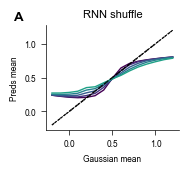

In [ ]:
fig, axes = plt.subplot_mosaic([['A']],
                            constrained_layout=False, figsize = [5/2.53, 4.5/2.53])
                            # constrained_layout=False, figsize = [12/2.53, 7/2.53])
import matplotlib.transforms as mtransforms
for label, ax in axes.items():
    # label physical distance to the left and up: (left, up) raise up to move label up
    trans = mtransforms.ScaledTranslation(-23/72, 2/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
        fontsize='large', va='bottom', fontfamily='arial',weight='bold')

with_context_color = 'tab:blue'
no_context_color = 'tab:orange'

means = np.array(list(range(-2, 13)))/10


########################### to do: continue refavctoricng from here..............

# plot inferred means
def plot_mean_std_lines(title, axes, means, all_distances_from_mean_RNN, all_inferred_means_RNN, all_mean_abs_errors_RNN):
    # change color scheme to viridis
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, 3+len(stds)))
    for si,std_ in enumerate(stds):
        distances_from_mean_RNN = all_distances_from_mean_RNN[si]
        inferred_means_RNN = all_inferred_means_RNN[si]
        mean_abs_errors_RNN = all_mean_abs_errors_RNN[si]

        ax = axes['A']
        inferred_RNN = [np.array(inferred_means_RNN[mean]).mean() for mean in means]
        stds_RNN = [np.array(inferred_means_RNN[mean]).std() for mean in means]
        ax.plot( means, inferred_RNN, label=f'std_' + str(std_), linewidth=1, color=colors[si])# color= no_context_color)
    # ax.fill_between(means, np.array(inferred_RNN) - np.array(stds_RNN), np.array(inferred_RNN) + np.array(stds_RNN), alpha=0.2, color= no_context_color)
        ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)
        axes_labels(ax, 'Gaussian mean', 'Preds mean')
    # ax.legend(fontsize=6)
        ax.set_title(title)


    # ax.set_title('inferred means')
    axes_labels(ax, 'Obs mean', 'Preds mean')
    # ax.legend(fontsize=6)
    # draw a diagonal line
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)



# plot inferred means
for si,std_ in enumerate(stds):
    distances_from_mean, inferred_means, mean_abs_errors = extract_gen_performance(memory_buffers_RNN_shuffle[si],envs_RNN_shuffle[si])
    distances_from_mean_RNN = all_distances_from_mean_RNN[si]
    inferred_means_RNN = all_inferred_means_RNN[si]
    mean_abs_errors_RNN = all_mean_abs_errors_RNN[si]

    ax = axes['A']
    inferred_RNN = [np.array(inferred_means_RNN[mean]).mean() for mean in means]
    stds_RNN = [np.array(inferred_means_RNN[mean]).std() for mean in means]
    ax.plot( means, inferred_RNN, label=f'STD ' + str(std_), linewidth=1, color=colors[si])# color= no_context_color)
    # ax.fill_between(means, np.array(inferred_RNN) - np.array(stds_RNN), np.array(inferred_RNN) + np.array(stds_RNN), alpha=0.2, color= no_context_color)
    ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    axes_labels(ax, 'Gaussian mean', 'Preds mean')
    # ax.legend(fontsize=6)
    ax.set_title('RNN shuffle')


# ax.set_title('inferred means')
axes_labels(ax, 'Gaussian mean', 'Preds mean')
# ax.legend(fontsize=6)
# draw a diagonal line
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.plot([-.2, 1.2], [-0.2, 1.2], color='k', linestyle='--', linewidth=1, alpha=0.5)
fig.tight_layout()
fig.savefig('./exports/RNN_shuffle_only_generalization2.PDF', dpi=300)